In [17]:
#!/usr/bin/env python
# coding: utf-8
from tqdm  import tqdm 
from tqdm import trange
from pyDOE import lhs
import torch
torch.cuda.empty_cache()

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

# import meshio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
warnings.filterwarnings('ignore')

from scipy.interpolate import RBFInterpolator

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 设置显示负号

np.random.seed(2023)
# 检查是否有可用的GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# torch.set_float32_matmul_precision('high')  #

Device: cuda


MESH

In [18]:
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import re
import numpy as np

def extract_mesh_from_inp(file_path):
    """
    从 Abaqus .inp 文件中提取节点和 C3D8R 元素信息，转换节点索引为 0-based。
    
    参数：
        file_path: .inp 文件路径。
    
    返回：
        nodes: list of (node_id, x, y, z)，节点 ID (0-based) 和坐标。
        elements: list of [node_id1, ..., node_id8]，单元的节点索引 (0-based)。
        node_sets: dict，节点集。
        element_type: str，单元类型（如 'C3D8R'）。
    """
    nodes = []
    elements = []
    node_sets = {}
    element_type = None

    with open(file_path, 'r') as f:
        reading_nodes = False
        reading_elements = False
        reading_nsets = False
        current_nset = None

        for line in f:
            line = line.strip()
            if line.startswith("*Node"):
                reading_nodes = True
                reading_elements = False
                reading_nsets = False
                continue
            elif line.startswith("*Element"):
                reading_nodes = False
                reading_elements = True
                reading_nsets = False
                element_type_match = re.search(r"type=(\w+)", line)
                element_type = element_type_match.group(1) if element_type_match else None
                continue
            elif line.startswith("*Nset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = True
                current_nset = line.split('=')[-1].strip()
                node_sets[current_nset] = []
                continue
            elif line.startswith("*End") or line.startswith("*Elset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = False
                continue
            if reading_nodes:
                node_data = re.split(r',\s*', line.strip())
                if len(node_data) >= 4:
                    try:
                        node_id = int(node_data[0]) - 1  # 转换为 0-based
                        x, y, z = map(float, node_data[1:4])
                        nodes.append((node_id, x, y, z))
                    except ValueError:
                        continue
            if reading_elements:
                element_data = re.split(r',\s*', line.strip())
                if len(element_data) >= 9:  # C3D8R: 1 element_id + 8 node_ids
                    try:
                        element_nodes = [int(n) - 1 for n in element_data[1:9]]  # 转换为 0-based
                        if element_type == "C3D8R" and len(element_nodes) == 8:
                            elements.append(element_nodes)
                        else:
                            print(f"Warning: Element {element_data[0]} skipped, invalid node count or type")
                    except ValueError:
                        print(f"Warning: Invalid element data in line: {line}")
                        continue
            if reading_nsets:
                if "generate" in line.lower():
                    node_ids = re.split(r',\s*', line.strip())
                    if len(node_ids) >= 3:
                        try:
                            start, end, step = map(int, node_ids[:3])
                            node_sets[current_nset].extend([n - 1 for n in range(start, end + 1, step)])
                        except ValueError:
                            continue
                else:
                    node_ids = re.split(r',\s*', line.strip())
                    if all(nid.strip().isdigit() for nid in node_ids if nid.strip()):
                        node_sets[current_nset].extend([int(nid) - 1 for nid in node_ids if nid.strip()])

    # 检查节点索引有效性
    max_node_id = max([n[0] for n in nodes]) if nodes else -1
    for e, elem in enumerate(elements):
        for nid in elem:
            if nid < 0 or nid > max_node_id:
                print(f"Error: Element {e+1} contains invalid node index {nid + 1} (0-based: {nid})")
                return [], [], {}, None

    return nodes, elements, node_sets, element_type
def plot_3d_mesh(nodes, elements):
    """
    绘制 C3D4 网格的三维线框可视化，跳过无效面
    :param nodes: 节点列表 [(node_id, x, y, z), ...]
    :param elements: 元素列表 [[node_id1, node_id2, node_id3, node_id4], ...]
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 提取节点坐标
    nodes_array = np.array([n[1:4] for n in nodes])  # (num_nodes, 3)
    invalid_faces = 0

    # 绘制四面体元素
    for e, node_ids in enumerate(elements):
        # 获取四面体四个节点的坐标
        coords = nodes_array[node_ids]  # (4, 3)
        if len(set(node_ids)) != 4:
            print(f"Warning: Element {e} has duplicate nodes: {node_ids}")
            continue

        x = coords[:, 0]
        y = coords[:, 1]
        z = coords[:, 2]

        # 定义四面体的面
        faces = [
            [0, 1, 2],  # 面1: 节点 0-1-2
            [0, 1, 3],  # 面2: 节点 0-1-3
            [0, 2, 3],  # 面3: 节点 0-2-3
            [1, 2, 3]   # 面4: 节点 1-2-3
        ]

        # 绘制每个面
        for face in faces:
            face_nodes = coords[face]  # (3, 3)
            x_face = face_nodes[:, 0]
            y_face = face_nodes[:, 1]
            z_face = face_nodes[:, 2]

            # 检查唯一点
            unique_points = len(np.unique(face_nodes, axis=0))
            if unique_points < 3:
                invalid_faces += 1
                print(f"Warning: Element {e}, face {face} has only {unique_points} unique points, skipping")
                continue

            # 检查三角形面积
            v1 = face_nodes[1] - face_nodes[0]
            v2 = face_nodes[2] - face_nodes[0]
            area = 0.5 * np.linalg.norm(np.cross(v1, v2))
            if area < 1e-10:
                invalid_faces += 1
                print(f"Warning: Element {e}, face {face} has near-zero area {area}, skipping")
                continue

            # 闭合三角形面
            x_face = list(x_face) + [x_face[0]]
            y_face = list(y_face) + [y_face[0]]
            z_face = list(z_face) + [z_face[0]]
            ax.plot(x_face, y_face, z_face, 'b-', alpha=0.05)

    print(f"Total invalid faces skipped: {invalid_faces}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Tetrahedral Mesh (C3D4)')

    plt.show()



单线段的R函数距离

In [19]:
def dist(x1, y1, z1, x2, y2, z2):
    """计算三维两点间距离"""
    return torch.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

def face_dist(x, y, z, v1, v2, v3, v4):
    """计算点 (x, y, z) 到四边形所在平面的距离，向量化"""
    eps = 1e-20
    # 提取四边形顶点坐标
    x1, y1, z1 = v1
    x2, y2, z2 = v2
    x3, y3, z3 = v3
    x4, y4, z4 = v4
    v1 = v1.to(device)
    v2 = v2.to(device)
    v3 = v3.to(device)
    v4 = v4.to(device)
    # 将顶点转换为张量
    v1_t = torch.tensor([x1, y1, z1])[:, None].to(device)
    v2_t = torch.tensor([x2, y2, z2])[:, None].to(device)
    v3_t = torch.tensor([x3, y3, z3])[:, None].to(device)
    v4_t = torch.tensor([x4, y4, z4])[:, None].to(device)

    # 计算法向量：使用两个三角形的平均法向量以提高准确性
    u1 = v2_t - v1_t
    u2 = v3_t - v1_t
    u3 = v4_t - v1_t
    normal1 = torch.cross(u1, u2, dim=0)  # v1-v2-v3 的法向量
    normal2 = torch.cross(u2, u3, dim=0)  # v1-v3-v4 的法向量
    normal = (normal1 + normal2) / 2.0  # 平均法向量
    norm = torch.sqrt(torch.sum(normal**2, dim=0) + eps)  # 法向量模长
    normal = normal / norm  # 归一化法向量

    # 点坐标张量，形状为 [3, n_points]
    p = torch.stack([x, y, z], dim=0).to(device)

    # 点到平面的距离：|n · (p - v1)|，向量化
    dist_to_plane = torch.abs(torch.sum(normal * (p - v1_t), dim=0))

    # 计算 varphi 和 phi_i
    varphi = torch.sqrt(dist_to_plane**2 + eps)
    phi_i = torch.sqrt(dist_to_plane**2 + (1.0 / 4.0) * varphi**2 + eps)
    return phi_i

def phi(x, y, z, faces, m=2.0):
    """多面体R函数距离，基于面集合"""
    x = x.to(device)
    y = y.to(device)
    z = z.to(device)
    faces = faces.to(device)

    
    R = torch.zeros_like(x)
    for i in range(len(faces)):
        v1, v2, v3, v4 = faces[i, 0], faces[i, 1], faces[i, 2], faces[i, 3]
        phi_i = face_dist(x, y, z, v1, v2, v3, v4)
        R += 1.0 / phi_i**m
    return (1.0 / R**(1.0 / m))

定义非同质边界条件 g(x)

In [20]:
def boundary_g(x, y, z, faces, bc_values):
    """超限插值构造 g(x, y, z)，基于面集合"""
    mu = 1.0
    eps = 1e-20  # 防止除零
    weights = []

    num_faces = faces.shape[0]
    
    # 计算每个三角形面的距离
    for i in range(num_faces):
        v1, v2, v3, v4 = faces[i, 0], faces[i, 1], faces[i, 2], faces[i, 3]
        phi_i = face_dist(x, y, z, v1, v2, v3, v4).reshape(-1,1)  # (num_points, 1)

        weights.append(phi_i**(-mu))
    


    # 堆叠权重
    weights = torch.stack(weights)  # (num_faces, num_points, 1)
 
    # 归一化权重
    weight_sum = torch.sum(weights, dim=0, keepdim=True)  # (1, num_points, 1)
    w = weights / torch.sum(weights, dim=0) # (num_faces, num_points, 1)

    # 处理边界条件值
    g_values = torch.tensor(bc_values, dtype=torch.float32, device=x.device)  # (num_faces,)
    
    # 计算 g
    g = torch.sum(w * g_values.view(-1, 1, 1), dim=0)  # (num_points, 1)
    return g


绘制距离函数云图

In [21]:
def plot_phi_cloud(nodes, faces):
    """
    绘制节点数组的 phi 值三维云图，使用指定的 faces
    """
    nodes_array = np.array([n[1:4] for n in nodes])  # 提取 x, y, z
    x = torch.tensor(nodes_array[:, 0], dtype=torch.float32)
    y = torch.tensor(nodes_array[:, 1], dtype=torch.float32)
    z = torch.tensor(nodes_array[:, 2], dtype=torch.float32)


    phi_values = phi(x, y, z, faces, m=2.0)
    phi_values = phi_values.numpy()
    x = x.numpy()
    y = y.numpy()
    z = z.numpy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=phi_values, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter, ax=ax, label='Phi Value')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Phi Value Cloud')

    plt.show()

shape function

In [23]:

def compute_shape_functions(nodes, elements):
    """
    计算C3D8R单元的体积、高斯点坐标、形函数值及其偏导数。
    参数：
        nodes: 节点坐标，形状为 (num_nodes, 3)，包含 (x, y, z)
        elements: 单元连接，形状为 (num_elements, 8)
        device: PyTorch 设备
    返回：
        volumes: 单元体积，形状为 (num_elements,)
        gauss_points: 高斯点坐标，形状为 (num_elements, 3)
        shape_vals: 形函数值，形状为 (num_elements, 8)
        shape_grads: 形函数偏导数，形状为 (num_elements, 8, 3)
    """
    num_elements = len(elements)
    num_nodes = nodes.shape[0]
    volumes = np.zeros(num_elements, dtype=np.float32)
    gauss_points = np.zeros((num_elements, 3), dtype=np.float32)
    shape_vals = np.zeros((num_elements, num_nodes), dtype=np.float32)
    shape_grads = np.zeros((num_elements, num_nodes, 3), dtype=np.float32)

    gauss_point = np.array([0.0, 0.0, 0.0])
    weight = 8.0

    for e, elem in enumerate(elements):
        node_coords = np.array([nodes[n] for n in elem])


        xi, eta, zeta = gauss_point
        # 形函数按输入节点顺序 [5, 6, 8, 7, 1, 2, 4, 3] 对应局部坐标
        N = np.array([
            (1-xi)*(1-eta)*(1-zeta)/8,  # inp 5: (-1,-1,-1)
            (1+xi)*(1-eta)*(1-zeta)/8,  # inp 6: ( 1,-1,-1)
            (1+xi)*(1+eta)*(1-zeta)/8,  # inp 8: ( 1, 1,-1)
            (1-xi)*(1+eta)*(1-zeta)/8,  # inp 7: (-1, 1,-1)
            (1-xi)*(1-eta)*(1+zeta)/8,  # inp 1: (-1,-1, 1)
            (1+xi)*(1-eta)*(1+zeta)/8,  # inp 2: ( 1,-1, 1)
            (1+xi)*(1+eta)*(1+zeta)/8,  # inp 4: ( 1, 1, 1)
            (1-xi)*(1+eta)*(1+zeta)/8   # inp 3: (-1, 1, 1)
        ])
        shape_vals[e, elem[0]] = N[0]
        shape_vals[e, elem[1]] = N[1]
        shape_vals[e, elem[2]] = N[2]
        shape_vals[e, elem[3]] = N[3]
        shape_vals[e, elem[4]] = N[4]
        shape_vals[e, elem[5]] = N[5]
        shape_vals[e, elem[6]] = N[6]
        shape_vals[e, elem[7]] = N[7]


        # 形函数导数按正确局部坐标
        dN_dxi = np.array([
            [-(1-eta)*(1-zeta)/8, -(1-xi)*(1-zeta)/8, -(1-xi)*(1-eta)/8],  # inp 5: (-1,-1,-1)
            [ (1-eta)*(1-zeta)/8, -(1+xi)*(1-zeta)/8, -(1+xi)*(1-eta)/8],  # inp 6: ( 1,-1,-1)
            [ (1+eta)*(1-zeta)/8,  (1+xi)*(1-zeta)/8, -(1+xi)*(1+eta)/8],  # inp 8: ( 1, 1,-1)
            [-(1+eta)*(1-zeta)/8,  (1-xi)*(1-zeta)/8, -(1-xi)*(1+eta)/8],  # inp 7: (-1, 1,-1)
            [-(1-eta)*(1+zeta)/8, -(1-xi)*(1+zeta)/8,  (1-xi)*(1-eta)/8],  # inp 1: (-1,-1, 1)
            [ (1-eta)*(1+zeta)/8, -(1+xi)*(1+zeta)/8,  (1+xi)*(1-eta)/8],  # inp 2: ( 1,-1, 1)
            [ (1+eta)*(1+zeta)/8,  (1+xi)*(1+zeta)/8,  (1+xi)*(1+eta)/8],  # inp 4: ( 1, 1, 1)
            [-(1+eta)*(1+zeta)/8,  (1-xi)*(1+zeta)/8,  (1-xi)*(1+eta)/8]   # inp 3: (-1, 1, 1)
        ]) #(8,3)


        J = dN_dxi.T@ node_coords

        det_J = np.linalg.det(J)
        # if det_J < 1e-10:
        #     print(f"Warning: Element {e} has near-zero Jacobian determinant: {det_J}")
        #     det_J = max(det_J, 1e-10)

        volumes[e] = abs(det_J) * weight
        # J_inv = np.linalg.inv(J)
        dN_dxyz = np.linalg.solve(J, dN_dxi.T).T
        # dN_dxyz = np.dot(dN_dxi, J_inv)
        shape_grads[e, elem[0], :] = dN_dxyz[0]
        shape_grads[e, elem[1], :] = dN_dxyz[1]
        shape_grads[e, elem[2], :] = dN_dxyz[2]
        shape_grads[e, elem[3], :] = dN_dxyz[3]
        shape_grads[e, elem[4], :] = dN_dxyz[4]
        shape_grads[e, elem[5], :] = dN_dxyz[5]
        shape_grads[e, elem[6], :] = dN_dxyz[6]
        shape_grads[e, elem[7], :] = dN_dxyz[7]
        

        gauss_points[e, :] = np.dot(N, node_coords)

    print("Volume range:", volumes.min(), volumes.max())
    return (
        torch.tensor(volumes, dtype=torch.float32),
        torch.tensor(gauss_points, dtype=torch.float32),
        torch.tensor(shape_vals, dtype=torch.float32),
        torch.tensor(shape_grads, dtype=torch.float32)
    )



#########  PINN  ######### 

In [25]:
# 均方误差 MSE
mse_loss = torch.nn.MSELoss() 

# 定义 MAE 损失(绝对误差)
mae_loss = nn.L1Loss()

In [27]:
import time
from torch.optim import lr_scheduler
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch.nn.init as init
class PINNs():
    def __init__(
        self, 
        activation, 
        device,
        initial_lr, sadap,
        rho, E, nu,
        faces_x, faces_y, faces_z, bc_x, bc_y,bc_z,
        gp,  gp_shape, gp_shape_grad, volumes,
        nodes,loss_threshold,
        beta_u, beta_v, beta_w,tag
        ):


        self.device = device
        # self.t_point = t_point
        ###  材料参数  ###
        self.lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
        self.G = E / (2 * (1 + nu))
        self.c11 = self.c22 = self.lambda_ + 2 * self.G
        self.c12 = self.c21 = self.lambda_
        self.c33 = self.G

        self.iter_res=0
        self.iter_phi=0
        self.rho = rho
           
        self.train_losses = []
        self.end_time = []

        self.faces_x = torch.tensor(faces_x, dtype=torch.float32, device=device)
        self.faces_y = torch.tensor(faces_y, dtype=torch.float32, device=device)
        self.faces_z = torch.tensor(faces_z, dtype=torch.float32, device=device)
        self.bc_x = torch.tensor(bc_x, dtype=torch.float32, device=device)
        self.bc_y = torch.tensor(bc_y, dtype=torch.float32, device=device)
        self.bc_z = torch.tensor(bc_z, dtype=torch.float32, device=device)

        self.gp = torch.tensor(gp, requires_grad=True, dtype=torch.float32, device=device)
        self.gp_shape = torch.tensor(gp_shape, dtype=torch.float32, device=device)
        self.gp_shape_grad_x = torch.tensor(gp_shape_grad[:, :, 0], dtype=torch.float32, device=device)
        self.gp_shape_grad_y = torch.tensor(gp_shape_grad[:, :, 1], dtype=torch.float32, device=device)
        self.gp_shape_grad_z = torch.tensor(gp_shape_grad[:, :, 2], dtype=torch.float32, device=device)

        self.volumes = torch.tensor(volumes, dtype=torch.float32, device=device)

        beta_init = 0.0  # 初始值
        ##u

        self.gp_x = self.gp[:, 0].reshape(-1, 1)  # [n_gp, 1]  
        self.gp_y = self.gp[:, 1].reshape(-1, 1)
        self.gp_z = self.gp[:, 2].reshape(-1, 1)


        self.mesh_nodes = torch.tensor(nodes, requires_grad=True).float().to(device)
        self.mesh_nodes_x = self.mesh_nodes[:, 0].reshape(-1, 1)  # [n_nodes, 1]
        self.mesh_nodes_y = self.mesh_nodes[:, 1].reshape(-1, 1)
        self.mesh_nodes_z = self.mesh_nodes[:, 2].reshape(-1, 1)

        if tag ==0:
        ####
            self.beta_u = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #
            self.beta_v = torch.full(self.mesh_nodes_y.shape, beta_init, requires_grad=True, device=device)  #
            self.beta_w = torch.full(self.mesh_nodes_z.shape, beta_init, requires_grad=True, device=device)
        else:
            self.beta_u = torch.tensor(beta_u, requires_grad=True, device=device)  #
            self.beta_v = torch.tensor(beta_v, requires_grad=True, device=device)
            self.beta_w = torch.tensor(beta_w, requires_grad=True, device=device)

        # if tag ==0:
        # ####

            
        #     self.beta_u = torch.empty(self.mesh_nodes_x.shape + (1,), requires_grad=True, device=device)  # 形状从 [n] 变为 [n, 1]
        #     init.xavier_uniform_(self.beta_u)  # 应用 Xavier 初始化
        #     self.beta_u = self.beta_u.squeeze(-1)  # 恢复为 [n]


        #     self.beta_v = torch.empty(self.mesh_nodes_y.shape + (1,), requires_grad=True, device=device)
        #     init.xavier_uniform_(self.beta_v)
        #     self.beta_v = self.beta_v.squeeze(-1)


        #     self.beta_w = torch.empty(self.mesh_nodes_z.shape + (1,), requires_grad=True, device=device)
        #     init.xavier_uniform_(self.beta_w)
        #     self.beta_w = self.beta_w.squeeze(-1)
            
        #     self.beta_u = torch.tensor(self.beta_u, requires_grad=True, device=device)  # 确保是张量
        #     self.beta_v = torch.tensor(self.beta_v, requires_grad=True, device=device)  # 确保是张量            
        #     self.beta_w = torch.tensor(self.beta_w, requires_grad=True, device=device)

        # else:
        #     self.beta_u = torch.tensor(beta_u, requires_grad=True, device=device)  #
        #     self.beta_v = torch.tensor(beta_v, requires_grad=True, device=device)
        #     self.beta_w = torch.tensor(beta_w, requires_grad=True, device=device)
        xx =  (torch.tensor(nodes).float().to(device))[:, 0]
        yy =  (torch.tensor(nodes).float().to(device))[:, 1]
        zz =  (torch.tensor(nodes).float().to(device))[:, 2]

        ##u
        self.phi_val_u = phi(xx, yy, zz, self.faces_x, m=2.0).reshape(-1, 1)
        self.g_val_u = boundary_g(xx, yy, zz, self.faces_x, self.bc_x)

        # print(self.phi_val_u.shape)
        ##v
        self.phi_val_v = phi(xx, yy, zz, self.faces_y, m=2.0).reshape(-1,1)
        self.g_val_v = boundary_g(xx, yy, zz, self.faces_y, self.bc_y)
        ##w
        self.phi_val_w = phi(xx, yy, zz, self.faces_z, m=2.0).reshape(-1,1)
        self.g_val_w = boundary_g(xx, yy, zz, self.faces_z, self.bc_z)

        ############################################


        # 优化器：使用相同的设置
        self.optimizer_res = torch.optim.LBFGS(
            [self.beta_u,self.beta_v,self.beta_w], 
            lr=initial_lr, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change = 1e-5 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # 使用强沃尔夫线搜索条件
        )


     
        self.sadap_res=sadap #自适应学习率（是否）  每次更新时将学习率乘以 0.9（即每 1000 次迭代后，学习率减小到 90%）


        self.optimizer_Adam_res = torch.optim.Adam(params=[self.beta_u,self.beta_v,self.beta_w], lr=initial_lr)


        if self.sadap_res:
            self.scheduler_res = lr_scheduler.StepLR(self.optimizer_Adam_res, step_size=1000, gamma=0.9)

     # def optim_Adam(self,model):
    #     opt_adam = torch.optim.Adam(params=model.parameters(), lr=self.initial_lr)
    #     return opt_adam
    def xavier_init(self,layer):
        """
        对神经网络层进行 Xavier 初始化，包括权重和偏置
        
        Parameters:
            - layer (torch.nn.Module): 神经网络层
            
        Notes:
            该函数用于初始化线性层（nn.Linear），使用 Xavier 初始化方法，即将权重初始化为均匀分布，
            将偏置初始化为零。
        """
        if isinstance(layer, nn.Linear):  # 检查是否为线性层
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化方法初始化权重
            nn.init.zeros_(layer.bias)  # 将偏置初始化为零

    


    #########################
    #######         #########
    #######  train  #########
    #######         #########
    #########################
    def closure_res(self):

        loss = self.lossf_res(
            td=None,
        )

        # self.iter += 1
        # if self.iter % 100 == 0:
        #     print(f'Loss: {loss.item():.6f}')

        self.optimizer_res.zero_grad()
        loss.backward()

        return loss
    
    def train_res(self, epochs):
 
        #开启训练模式
        # model = self.uv_dnn
        # model.train()
        self.lossf_res = self.loss_res_all
        self.start_time = time.time()  # 记录迭代开始时间
        
        with trange(epochs, dynamic_ncols=True, ncols=1) as td:
            for epoch in td:



                loss = self.lossf_res(td=td, print_str="", loss_model=mse_loss)

                self.train_losses.append(loss)
                self.end_time.append(time.time())  # 记录时间
                self.iter_res += 1
                if loss.item() < loss_threshold:
                    print(f"Stopping early at epoch {epoch} as loss {loss.item()} < {loss_threshold}")
                    break
                
                # 反向传播和优化
                self.optimizer_Adam_res.zero_grad()
#                 if torch.isnan(loss).any():
#                     print("Loss contains NaN values. Check your model and input data.")
                loss.backward()
                self.optimizer_Adam_res.step()

                if self.sadap_res:
                    self.scheduler_res.step()
    
        # self.optimizer_res.step(closure=self.closure_res)


    ##########################################
    def predict_res(self):
        # 模型 评估模式
        
        UVWi = self.trial_function()#(1562,3)
        Ui = UVWi[:, 0]
        Vi = UVWi[:, 1]
        Wi = UVWi[:, 2] 

        # 计算一阶导数
        u_x =  self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  self.gp_shape_grad_y @ Ui  # [N, 1]
        u_z =  self.gp_shape_grad_z @ Ui

        v_x =  self.gp_shape_grad_x @ Vi  # [N, 1]
        v_y =  self.gp_shape_grad_y @ Vi  # [N, 1]
        v_z =  self.gp_shape_grad_z @ Vi

        w_x =  self.gp_shape_grad_x @ Wi  # [N, 1]
        w_y =  self.gp_shape_grad_y @ Wi  # [N, 1]
        w_z =  self.gp_shape_grad_z @ Wi
        ####   应变
        epsilon_x = u_x  # ε_x = ∂u/∂x, [num_elements, 1]
        epsilon_y = v_y  # ε_y = ∂v/∂y, [num_elements, 1]
        epsilon_z = w_z  # ε_z = ∂w/∂z, [num_elements, 1]
        gamma_xy = u_y + v_x  # γ_xy = ∂u/∂y + ∂v/∂x, [num_elements, 1]
        gamma_yz = v_z + w_y  # γ_yz = ∂v/∂z + ∂w/∂y, [num_elements, 1]
        gamma_zx = w_x + u_z  # γ_zx = ∂w/∂x + ∂u/∂z, [num_elements, 1

        # 计算应力（各向同性材料）
        sigma_x = self.c11 * epsilon_x + self.c12 * (epsilon_y + epsilon_z)  # σ_x
        sigma_y = self.c11 * epsilon_y + self.c12 * (epsilon_x + epsilon_z)  # σ_y
        sigma_z = self.c11 * epsilon_z + self.c12 * (epsilon_x + epsilon_y)  # σ_z
        tau_xy = self.c33 * gamma_xy  # τ_xy
        tau_yz = self.c33 * gamma_yz  # τ_yz
        tau_zx = self.c33 * gamma_zx  # τ_zx
        
        u = self.gp_shape @ Ui
        v = self.gp_shape @ Vi
        w = self.gp_shape @ Wi


        output = torch.stack((u, v, w, sigma_x,sigma_y,sigma_z,tau_xy,tau_yz,tau_zx), dim=1)

        return output

  
    def trial_function(self):
        """试探函数：u = g(x) + phi(x) * u_nn"""


        
        u = self.g_val_u + self.phi_val_u * self.beta_u
        v = self.g_val_v + self.phi_val_v * self.beta_v 

        w = self.g_val_w + self.phi_val_w * self.beta_w

        
        uvw = torch.cat([u, v, w], dim=1)  # 拼接为 [N, 3] 的张量




        return uvw   



    ####  能量函数   ####
    def compute_energy(self):
        """
        计算总应变能
        参数：
            coords: 高斯积分点坐标，形状为 [num_elements, 3]
        返回：
            energy: 总能量（标量）
        """

        UVWi = self.trial_function()#(1562,3)
        Ui = UVWi[:, 0]
        Vi = UVWi[:, 1]
        Wi = UVWi[:, 2] 

        # 计算一阶导数
        u_x =  self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  self.gp_shape_grad_y @ Ui  # [N, 1]
        u_z =  self.gp_shape_grad_z @ Ui

        v_x =  self.gp_shape_grad_x @ Vi  # [N, 1]
        v_y =  self.gp_shape_grad_y @ Vi  # [N, 1]
        v_z =  self.gp_shape_grad_z @ Vi

        w_x =  self.gp_shape_grad_x @ Wi  # [N, 1]
        w_y =  self.gp_shape_grad_y @ Wi  # [N, 1]
        w_z =  self.gp_shape_grad_z @ Wi
        ####   应变
        epsilon_x = u_x  # ε_x = ∂u/∂x, [num_elements, 1]
        epsilon_y = v_y  # ε_y = ∂v/∂y, [num_elements, 1]
        epsilon_z = w_z  # ε_z = ∂w/∂z, [num_elements, 1]
        gamma_xy = u_y + v_x  # γ_xy = ∂u/∂y + ∂v/∂x, [num_elements, 1]
        gamma_yz = v_z + w_y  # γ_yz = ∂v/∂z + ∂w/∂y, [num_elements, 1]
        gamma_zx = w_x + u_z  # γ_zx = ∂w/∂x + ∂u/∂z, [num_elements, 1

        # 计算应力（各向同性材料）
        sigma_x = self.c11 * epsilon_x + self.c12 * (epsilon_y + epsilon_z)  # σ_x
        sigma_y = self.c11 * epsilon_y + self.c12 * (epsilon_x + epsilon_z)  # σ_y
        sigma_z = self.c11 * epsilon_z + self.c12 * (epsilon_x + epsilon_y)  # σ_z
        tau_xy = self.c33 * gamma_xy  # τ_xy
        tau_yz = self.c33 * gamma_yz  # τ_yz
        tau_zx = self.c33 * gamma_zx  # τ_zx


        # 计算能量密度
        energy_density_ = 0.5 * (
        sigma_x * epsilon_x +
        sigma_y * epsilon_y +
        sigma_z * epsilon_z +
        tau_xy * gamma_xy +
        tau_yz * gamma_yz +
        tau_zx * gamma_zx
        )  # [num_elements, 1]

        energy_density = energy_density_.squeeze(-1)  # [num_elements]


        

        # 计算总能量
        energy = torch.sum(energy_density * self.volumes)


        
        return energy
    
    def loss_RES(self, loss):
     
        energy = self.compute_energy()  # [num_elements, 1]
        star = torch.zeros_like(energy).reshape(-1, 1)

  
        loss_res = loss(energy, star)
        return loss_res       
    # def loss_RES(self):
    #     return self.compute_energy()
    

#############################################  
    def loss_res_all(self, td=None, print_str="", loss_model=mse_loss):
        loss_res = self.loss_RES(loss_model)  
        loss_all = loss_res
        
        if td is not None:
            td.set_description(f"ALL: {loss_res.item():.7f}"+print_str)
        
        return loss_all    



In [ ]:

# 指定 .inp 文件路径
# file_path_ = r"D:\PINN\Strong_imposed\3D\cylinder.inp"  
# txt_path = r"D:\Jupyter\CW_hidenn\txt\cylinder"
faces_x = torch.tensor([
# 底面 (z=0)
[[-0.2, -0.2, 0.0], [-0.2, 0.2, 0.0],  [0.2, 0.2, 0.0],[0.2, -0.2, 0.0]],
# 顶面 (z=4)
[[-0.2, -0.2, 0.6], [-0.2, 0.2, 0.6],  [0.2, 0.2, 0.6],[0.2, -0.2, 0.6]]
])
##
faces_y = torch.tensor([
# 底面 (z=0)
[[-0.2, -0.2, 0.0], [-0.2, 0.2, 0.0],  [0.2, 0.2, 0.0],[0.2, -0.2, 0.0]],
# 顶面 (z=4)
[[-0.2, -0.2, 0.6], [-0.2, 0.2, 0.6],  [0.2, 0.2, 0.6],[0.2, -0.2, 0.6]]
])
##
faces_z = torch.tensor([
# 底面 (z=0)
[[-0.2, -0.2, 0.0], [-0.2, 0.2, 0.0],  [0.2, 0.2, 0.0],[0.2, -0.2, 0.0]],
# 顶面 (z=4)
[[-0.2, -0.2, 0.6], [-0.2, 0.2, 0.6],  [0.2, 0.2, 0.6],[0.2, -0.2, 0.6]]
])
# 调用提取函数

nodes, elements, node_sets, element_type = extract_mesh_from_inp(file_path_)

print(f"成功提取网格信息：")
print(f"节点数: {len(nodes)}")
print(f"元素数: {len(elements)}")
print(f"节点集: {list(node_sets.keys())}")
print(f"元素类型: {element_type}")


# plot_3d_mesh(nodes, elements)
# plot_phi_cloud(nodes, faces_x)
# # plot_phi_cloud(nodes, faces_y)
# plot_phi_cloud(nodes, faces_z)




nodes = np.array([n[1:4] for n in nodes])  # 提取 x, y, z
# nodes = nodes[:, [2, 0, 1]]
# cc =  nodes[:,0]
# nodes[:,0] = nodes[:,2]
# nodes[:,2] = nodes[:,1]
# nodes[:,1] = cc
elements = np.array(elements)  # 直接使用节点索引

### 生成积分点,单元面积 ###
# volumes,gp = generate_gp(nodes, elements)
volumes,gp, gp_shape, gp_shape_grad = compute_shape_functions(nodes, elements)


##########

activation='tanh'
initial_lr=0.01
sadap = True
rho, E, nu = 1.0, 5000, 0.3


bc_x = [0,0]
bc_y = [0,0]
bc_z = [0,-0.1]

成功提取网格信息：
节点数: 15562
元素数: 14070
节点集: ['ALL, generate', 'Part-1-1, generate']
元素类型: None
Volume range: 2.0998339e-06 9.314083e-06


In [29]:
beta_init = 0.0
loss_threshold = 29.28

beta_u = torch.full(nodes[:, 0].shape, beta_init, requires_grad=True,device=device)  #
beta_v = torch.full(nodes[:, 0].shape, beta_init,  requires_grad=True,device=device)  #
beta_w = torch.full(nodes[:, 0].shape, beta_init, requires_grad=True,device=device)

# # 初始化模型
model = PINNs(
    activation, 
    device,
    initial_lr, sadap,
    rho, E, nu,
    faces_x, faces_y, faces_z, bc_x, bc_y,bc_z,
    gp,  gp_shape, gp_shape_grad, volumes,
    nodes,
    loss_threshold,
    beta_u, beta_v, beta_w,tag=0
)


MAIN

In [30]:
model.train_res(epochs=50000)

ALL: 29.2797184:   0%|          | 105/50000 [00:01<10:45, 77.34it/s]

Stopping early at epoch 105 as loss 29.27971839904785 < 29.28


PLOT

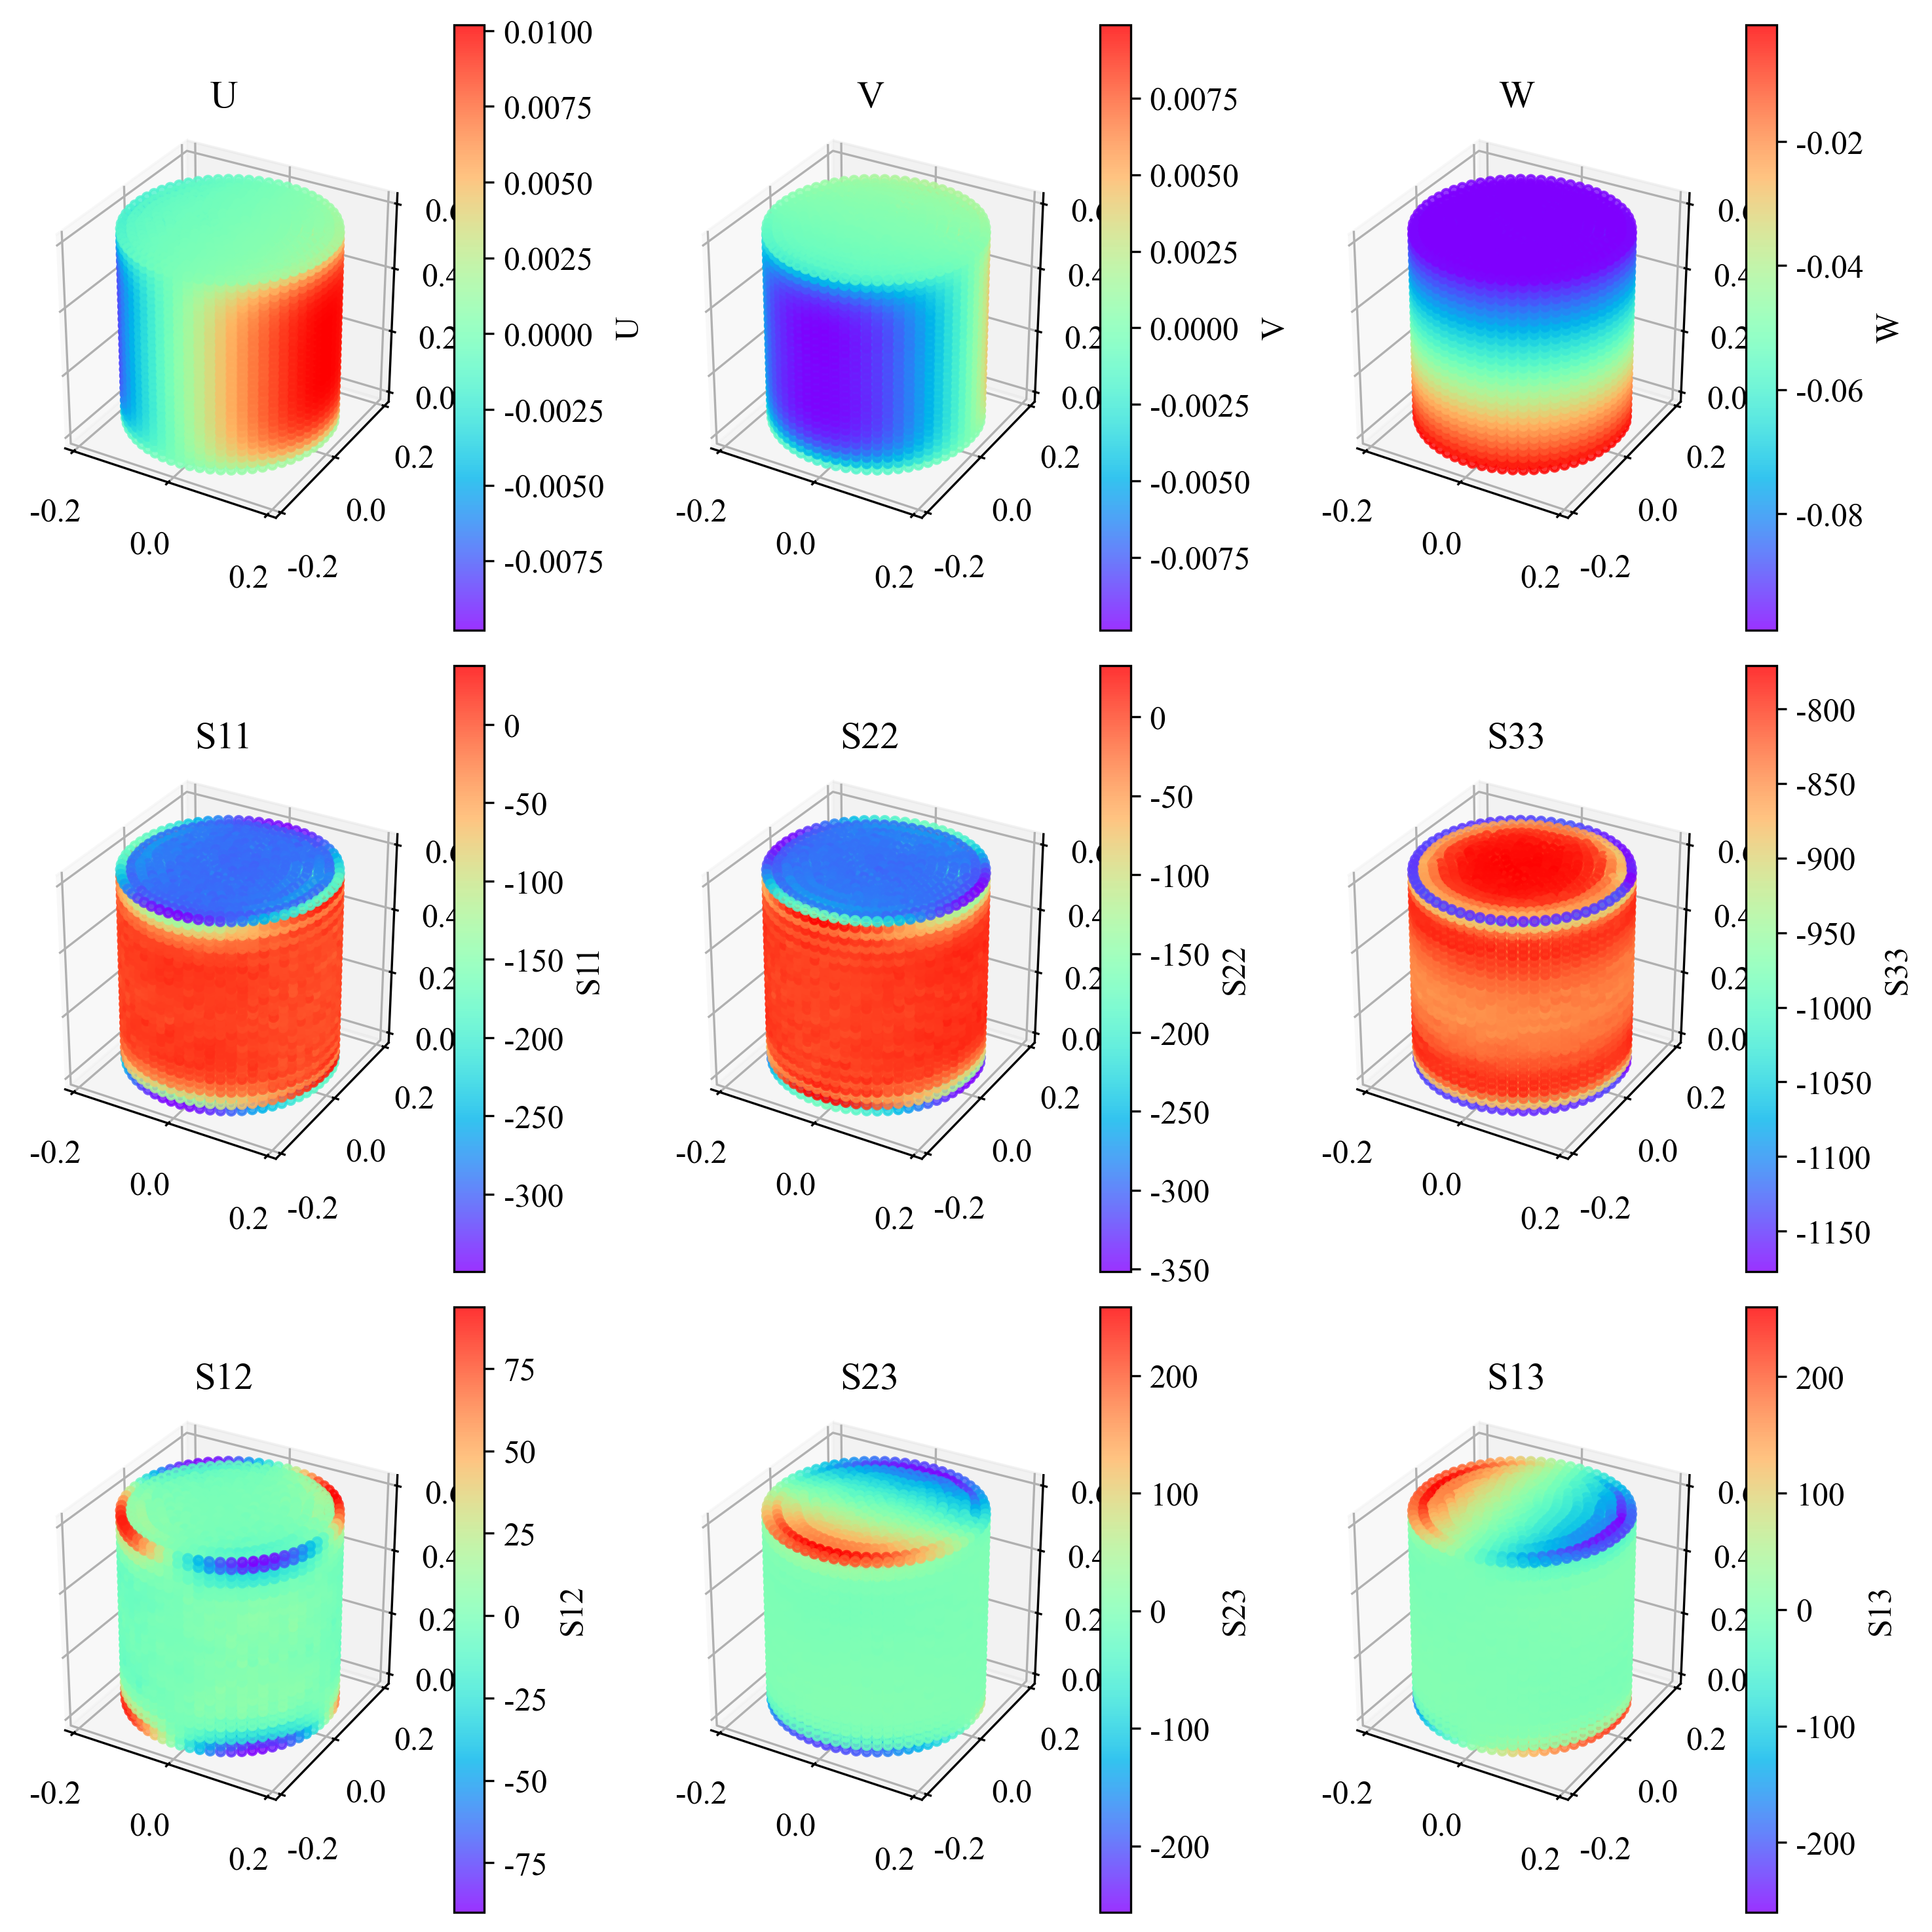

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def plot_3d_field(ax, X, Y, Z, C, title):
    """
    简单的三维散点图，绘制高斯积分点的标量场
    参数：
        ax: matplotlib 3D 轴对象
        X, Y, Z: 高斯积分点坐标，shape=(6108,)
        C: 标量场值，shape=(6108,)
        title: 子图标题
    """
    scatter = ax.scatter(X, Y, Z, c=C, cmap='rainbow', s=10, alpha=0.8)
    ax.set_box_aspect([1, 1, 1])  # 等比例轴
    ax.set_title(title, fontsize=14)

    plt.colorbar(scatter, ax=ax, label=title)

# 数据准备
if isinstance(gp, torch.Tensor):
    gp = gp.cpu().detach().numpy()  # shape=(6108, 3)

X = gp[:, 0]  # shape=(6108,)
Y = gp[:, 1]
Z = gp[:, 2]
output = model.predict_res().cpu().detach().numpy()  # shape=(6108, 5)

# 合并 u 和 v，计算位移模
u = output[:, 0]  # shape=(6108,)
v = output[:, 1]  # shape=(6108,)
w = output[:, 2]  # shape=(6108,)   
u_tensor = torch.tensor(u, dtype=torch.float32)
v_tensor = torch.tensor(v, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)
uvw = torch.stack((u_tensor, v_tensor,w_tensor), dim=1)  # shape=(6108, 2)
uvw_magnitude = torch.norm(uvw, dim=1).numpy()  # shape=(6108,)

# 创建 3x2 子图
fig = plt.figure(figsize=(10, 10), dpi=300)
ax1 = fig.add_subplot(331, projection='3d')
ax2 = fig.add_subplot(332, projection='3d')
ax3 = fig.add_subplot(333, projection='3d')
ax4 = fig.add_subplot(334, projection='3d')
ax5 = fig.add_subplot(335, projection='3d')
ax6 = fig.add_subplot(336, projection='3d')
ax7 = fig.add_subplot(337, projection='3d')
ax8 = fig.add_subplot(338, projection='3d')
ax9 = fig.add_subplot(339, projection='3d')


# 绘制所有字段
plot_3d_field(ax1, X, Y, Z, output[:, 0], "U")
plot_3d_field(ax2, X, Y, Z, output[:, 1], "V")
plot_3d_field(ax3, X, Y, Z, output[:, 2], "W")
plot_3d_field(ax4, X, Y, Z, output[:, 3], "S11")
plot_3d_field(ax5, X, Y, Z, output[:, 4], "S22")
plot_3d_field(ax6, X, Y, Z, output[:, 5], "S33")
plot_3d_field(ax7, X, Y, Z, output[:, 6], "S12")
plot_3d_field(ax8, X, Y, Z, output[:, 7], "S23")
plot_3d_field(ax9, X, Y, Z, output[:, 8], "S13")

plt.tight_layout()
plt.show()
np.savetxt(txt_path+'\\'+'s_cw.txt', output, delimiter=' ')
np.savetxt(txt_path+'\\'+'coord_cw.txt', gp, delimiter=' ')